<a href="https://colab.research.google.com/github/hyunus/SYDE-522/blob/master/Copy_of_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Data Preprocessing, Parameter Tuning, Model Evaluation Using SVM, K-NN, K-means, SOM

## What you will learn

* Data preprocessing
* Parameter Tuning
* Model evaluation
* Employing SVM and K-NN methods on the data
* kmeans objective function and color quantization kmeans clustering
* SOM for color mapping


## Submission
* Do not change any variable/function names.
* Just add your own code and don't change existing code
* Save this file and rename it to be **studentid_lastname.ipynb** (student id (underscore) last name.ipynb) where your student id is all numbers.
* Export your .ipynb file to PDF (File > Download as > PDF via Latex). **Please don't leave this step for final minutes**.
* Submit both the notebook and PDF files (**NO ZIP, RAR,..**).
* If you happen to use any external library not included in Anaconda (mention in **Submission Notes** section below)
* Deadline: February 26 at 11:55 pm
* Late assignments will be penalized with 10% per day.



In [0]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
import itertools
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# remove the following statements if you like to see warnings
import warnings
warnings.filterwarnings('ignore')

## Submission Notes
(Please write any notes here that you think I should know during marking)

# [NO MARKS]  Warming Up
Various interesting machine learning datasets can be found at:
- https://archive.ics.uci.edu/ml/index.php

For this task, we have chosen the Heart Disease dataset, available at:
- https://archive.ics.uci.edu/ml/datasets/heart+Disease

**Data Set Information**

- The dataset contains **303 subjects** with **76 attributes**. 
- All the published experiments refer to using a subset of **14 of attributes**. 
- The **goal** field in the dataset refers to **the presence of heart disease** in the patient. 
- It is integer valued from 0 (no presence) to 4 (highest presence). 

**Note:** Since the class number 4 is very sparse (just 13 subjects). We have dropped the subjects belonging to class 4 from the data.

Experiments with the Cleveland dataset have concentrated on---attempting to distinguish **the presence** (values 1, 2, 3, 4) from **the absence** (value 0).

**Attribute Information**

14 attributes are been used: 

1. #3 (age) 
2. #4 (sex) 
3. #9 (cp) 
4. #10 (trestbps) 
5. #12 (chol) 
6. #16 (fbs) 
7. #19 (restecg) 
8. #32 (thalach) 
9. #38 (exang) 
10. #40 (oldpeak) 
11. #41 (slope) 
12. #44 (ca) 
13. #51 (thal) 
14. #58 (num) (the predicted attribute)


### (no marks) Reading the data


In [0]:

!wget http://dev1-kimia.uwaterloo.ca:5000/data/ass2/processed_cleveland.csv

--2020-02-26 19:33:27--  http://dev1-kimia.uwaterloo.ca:5000/data/ass2/processed_cleveland.csv
Resolving dev1-kimia.uwaterloo.ca (dev1-kimia.uwaterloo.ca)... 129.97.229.28
Connecting to dev1-kimia.uwaterloo.ca (dev1-kimia.uwaterloo.ca)|129.97.229.28|:5000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18461 (18K) [text/csv]
Saving to: ‘processed_cleveland.csv’

processed_cleveland 100%[===================>]  18.03K  --.-KB/s    in 0.04s   

2020-02-26 19:33:27 (499 KB/s) - ‘processed_cleveland.csv’ saved [18461/18461]



In [0]:
# Reading the data-set

df_original = pd.read_csv('/content/processed_cleveland.csv', header=None)
df_original.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 
                       'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'prediction']
print('Data-set shape: ',df_original.shape)

df_original.tail(n=10)

Data-set shape:  (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,prediction
293,63.0,1.0,4.0,140.0,187.0,0.0,2.0,144.0,1.0,4.0,1.0,2.0,7.0,2
294,63.0,0.0,4.0,124.0,197.0,0.0,0.0,136.0,1.0,0.0,2.0,0.0,3.0,1
295,41.0,1.0,2.0,120.0,157.0,0.0,0.0,182.0,0.0,0.0,1.0,0.0,3.0,0
296,59.0,1.0,4.0,164.0,176.0,1.0,2.0,90.0,0.0,1.0,2.0,2.0,6.0,3
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0



### (no marks) Removing the missing data
There are many missing data marked by '?' in the dataset. We will use *dropping* as the most straight-forward technique for removing such data-points.

In [0]:
# Removing all subjects from class 4
df = df_original.loc[df_original.prediction != 4]

# Replacing the missing data '?' with NAN values
df.replace('?', np.nan, inplace=True) 
df = df.dropna()
df = df.astype(float)


### (no marks) Splitting the data


In [0]:
# Separating the data and the labels
X = np.asarray(df[df.columns[:-1]]).astype(np.float32)
y = np.asarray(df.prediction)

# Splitting the data into the train and the test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(X, y)

train_index, test_index = next(sss.split(X, y))
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]
    
print('Training data: \n',X_train)
print('\n')
print('Training labels: \n',y_train)

Training data: 
 [[45.  0.  4. ...  2.  0.  3.]
 [41.  1.  2. ...  2.  0.  6.]
 [42.  1.  4. ...  1.  0.  3.]
 ...
 [67.  1.  4. ...  2.  2.  7.]
 [65.  1.  4. ...  2.  1.  7.]
 [62.  0.  4. ...  1.  0.  3.]]


Training labels: 
 [0. 0. 0. 1. 0. 3. 0. 0. 0. 1. 1. 3. 0. 1. 1. 0. 2. 3. 0. 1. 3. 3. 0. 0.
 0. 2. 0. 0. 3. 0. 0. 0. 3. 1. 2. 0. 0. 3. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 3. 1. 2. 0. 2. 2. 0. 0. 0. 0. 1. 3. 1. 0. 2. 0. 0. 0. 0. 1. 0. 0. 0.
 3. 0. 0. 0. 1. 0. 0. 0. 3. 1. 0. 0. 1. 1. 1. 0. 0. 3. 0. 0. 0. 2. 2. 0.
 0. 0. 0. 0. 0. 3. 0. 2. 2. 2. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 2.
 2. 0. 0. 1. 0. 0. 0. 1. 3. 0. 0. 0. 0. 0. 0. 2. 2. 1. 2. 0. 1. 0. 2. 0.
 3. 1. 0. 0. 0. 3. 0. 0. 0. 2. 2. 0. 2. 1. 0. 0. 0. 3. 3. 0. 0. 0. 0. 1.
 0. 1. 3. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 3. 0. 1. 0. 0. 3. 0. 2. 3. 0. 0.
 0. 0. 2. 0. 1. 1. 0. 0. 3. 0. 2. 1. 0. 2. 2. 0. 0. 0. 1. 0. 0. 0. 3. 1.
 2. 0. 3. 0. 0. 3. 0. 3. 1. 2. 0.]


## [10 marks] Data Exploration

a) (3 marks) Use `pandas` to find the ratio of the presence of disease versus the absence within the different `sex`.

**Note:** `0` is female and `1` is male.

In [0]:
# we have defined a new column which is `true` if there is a presence of disease (i.e., prediction is [1, 2, 3])
df['has_disease'] = df.apply(lambda x: x.prediction in [1, 2, 3], axis=1)

# use groupby and aggregation
print(df.groupby('sex').mean()['has_disease'])
print(df.groupby('sex').count()['has_disease'])

sex
0.0    0.244681
1.0    0.531579
Name: has_disease, dtype: float64
sex
0.0     94
1.0    190
Name: has_disease, dtype: int64


ANSWER: For the 94 females, approximately 24.5% of them have the disease. For the 190 males, approximately 53.2% of them have the disease.

b) (7 marks) Do the same thing for age. Split the age groups as follows (left included, right isn't):

1. [29, 49)
2. [49, 69)
3. [69, inf)

And then find the average ratio of prevalence of the heart disease within the each group.

In [0]:
# write your code here

ages = [29, 49, 69, 110]
labels = ['Adult', "Middle-Aged", "Senior"]
df['age_group'] = pd.cut(df['age'], bins=ages, labels=labels, right=False)
print(df.groupby('age_group').mean()['has_disease'])
print(df.groupby('age_group').count()['has_disease'])

age_group
Adult          0.278481
Middle-Aged    0.510309
Senior         0.272727
Name: has_disease, dtype: float64
age_group
Adult           79
Middle-Aged    194
Senior          11
Name: has_disease, dtype: int64


ANSWER: For the 79 Adults, approximately 27.8% of them have the disease. For the 194 Middle Aged people, approximately 51% of them have the disease. For the 11 Seniors, approximately 27.3% of them have the disease.

### (no marks) Utility function

In [0]:
# Do not change the function
# This function is adapted from the sklearn website
# This function let you draw a confusion matrix for your problem

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[1 2]
 [3 4]]


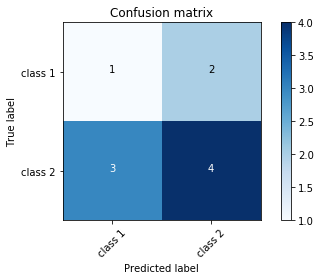

In [0]:
# usage
plot_confusion_matrix(np.array([[1, 2], [3, 4]]), ['class 1', 'class 2'])

# Task 1 [10 marks]

### a) [4 marks] Applying KNN to the data

              precision    recall  f1-score   support

         0.0       0.63      0.91      0.74        32
         1.0       0.17      0.09      0.12        11
         2.0       0.50      0.14      0.22         7
         3.0       0.33      0.14      0.20         7

    accuracy                           0.56        57
   macro avg       0.41      0.32      0.32        57
weighted avg       0.49      0.56      0.49        57

Confusion matrix, without normalization
[[29  3  0  0]
 [ 8  1  1  1]
 [ 5  0  1  1]
 [ 4  2  0  1]]


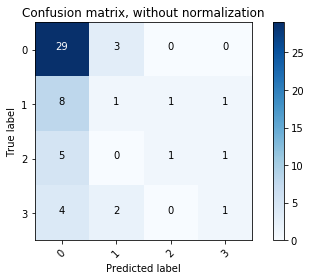

In [0]:
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.preprocessing import MinMaxScaler

# Task 2
# Add your code in the following part:

# We use min max scaler to normalize the features between [0, 1] 
scaler = MinMaxScaler()

# Add your code here instead of ...
scaler.fit(X_train)

# Create a knn classifier instance here (If you don't add anything here, your code won't execute!)
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Fit the classifier using the train data (If you don't add anything here, your code won't execute!)
knn_clf.fit(X_train, y_train)

# Predict the test class labels using the trained classifier (If you don't add anything here, your code won't execute!)
y_pred = knn_clf.predict(X_test)

# (If you don't add anything here, your code won't execute!) 
print(classification_report(y_test, y_pred))

cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3],
                      title='Confusion matrix, without normalization')

### b) [3 marks] Between $K=3$ and $k=5$ which one gives more  accuracy ?

In [0]:
from sklearn.metrics import accuracy_score

# write your code here and populate `y_pred_k5` and `y_pred_k3`

#knn instances
knn_clf3 = KNeighborsClassifier(n_neighbors=3)
knn_clf5 = KNeighborsClassifier(n_neighbors=5)

#fit classifiers with training data
knn_clf3.fit(X_train, y_train)
knn_clf5.fit(X_train, y_train)

#predict test class labels 
y_pred_k3 = knn_clf3.predict(X_test)
y_pred_k5 = knn_clf5.predict(X_test)

print(accuracy_score(y_test, y_pred_k5), accuracy_score(y_test, y_pred_k3))

0.5614035087719298 0.5263157894736842


ANSWER: Here, we see an accuracy score of 0.56 for k=5 and an accuracy score of 0.53 for k=3. This indicates that k=5 gives more accuracy.

### c) [3 marks] Between $\ell_1$, $\ell_2$, and $cosine$ similarity which one is better in term of accuracy?

In [0]:
# write your code here to experiment with different distance metrics
# use argument `metric` to change to a different distance by default it is euclidean distance 

#initialize classifiers
knn_clf_man = KNeighborsClassifier(metric='manhattan')
knn_clf_mink = KNeighborsClassifier(metric='minkowski') 
knn_clf_cos = KNeighborsClassifier(metric='cosine')

#fit classifiers
knn_clf_man.fit(X_train, y_train)
knn_clf_mink.fit(X_train, y_train)
knn_clf_cos.fit(X_train, y_train)

#predict
y_pred_man = knn_clf_man.predict(X_test)
y_pred_mink = knn_clf_mink.predict(X_test)
y_pred_cos = knn_clf_cos.predict(X_test)

#print accuracies

print(accuracy_score(y_test, y_pred_man), accuracy_score(y_test, y_pred_mink), accuracy_score(y_test, y_pred_cos))



0.5789473684210527 0.5614035087719298 0.45614035087719296


ANSWER: Out of Manhattan, Minkowski, and Cosine distance, Manhattan distance has the greatest accuracy.

# Task 2 [10 marks]

### Understanding the pipelining architecture of `Sklearn`

In the code above, you had to call `scaler` for every prediction by a model. This can be avoided by using a `pipeline` mechanism within sklearn. Look at the code below:

1. We create a data scaler (can be any sclaer with fit and transform functions).
2. We create SVC object (again with fit and transform functions).
3. Then we create a pipeline: `data --> scaler --> svc --> fit`.
4. The same transformation is also applied during the prediction phase.

We further use a `GridSearchCV` for the SVC's parameters tuning.

In [0]:
# Task 2

# Creating a SVM classifier instance
svc = SVC()

# Add a scaler here (If you don't add anything here, your code won't execute!)
data_scaler = StandardScaler()

# Update the pipeline by adding the scaler from the previous line
model = make_pipeline(data_scaler, svc)
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}

grid = GridSearchCV(model, param_grid)
%time grid.fit(X_train, y_train)
print( grid.best_estimator_)

CPU times: user 356 ms, sys: 1.3 ms, total: 357 ms
Wall time: 362 ms
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=50, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.001, kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)


In [0]:
# Selecting the best estimator after the parameter search
model = grid.best_estimator_

In [0]:
# Predicting the test labels
y_pred = model.predict(X_test)

In [0]:
# Printing the classification report
print(classification_report(y_pred=y_pred,y_true=y_test))

              precision    recall  f1-score   support

         0.0       0.78      0.97      0.86        32
         1.0       0.43      0.27      0.33        11
         2.0       0.33      0.29      0.31         7
         3.0       0.25      0.14      0.18         7

    accuracy                           0.65        57
   macro avg       0.45      0.42      0.42        57
weighted avg       0.59      0.65      0.61        57



Confusion matrix, without normalization
[[31  0  1  0]
 [ 7  3  1  0]
 [ 1  1  2  3]
 [ 1  3  2  1]]


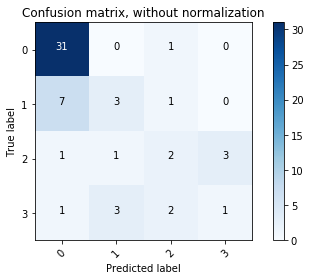

In [0]:
# Computing the confusion matrix for the test data
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix using the previous function
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3],
                      title='Confusion matrix, without normalization')

# Task 3 [20 marks]

### How to handle the missing data

More information can be found here:
(https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html)

a) [4 scores] Name two numeric methods for dealing with the missing data (except dropping):
    
    Write the answer here:
    
    1- Fill missing data with a scalar.
    
    2- Fill missing data with propogating values forward.
    

b) [6 scores] Apply the methods that you mentioned in part (a) to the `df_with_missing_data` dataframe:

In [0]:
# Task 3 part (b)
# Add your code here (If you don't add anything here, your code won't execute!)

df_with_missing_data = pd.read_csv('/content/processed_cleveland.csv', header=None)
df_with_missing_data.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 
                                'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'prediction']
#replace '?' with nan
df_with_missing_data.replace('?', np.nan, inplace=True) 

#Fill in with a scalar
df_1 = df_with_missing_data.fillna(2)

#Fill in with propagated values
df_2 = df_with_missing_data.fillna(method='pad')

#convert strings to floats
df_1 = df_1.astype(float)
df_2 = df_2.astype(float)


c) [10 scores] Apply the steps described in *Task 2* on `df_1` and `df_2` and show the results using `classification_report` and `plot_confusion_matrix`.

              precision    recall  f1-score   support

         0.0       0.78      0.94      0.85        33
         1.0       0.17      0.18      0.17        11
         2.0       0.20      0.14      0.17         7
         3.0       0.00      0.00      0.00         7
         4.0       0.00      0.00      0.00         3

    accuracy                           0.56        61
   macro avg       0.23      0.25      0.24        61
weighted avg       0.47      0.56      0.51        61

Confusion matrix, without normalization
[[31  2  0  0  0]
 [ 6  2  1  2  0]
 [ 2  3  1  1  0]
 [ 1  4  2  0  0]
 [ 0  1  1  1  0]]
              precision    recall  f1-score   support

         0.0       0.79      0.94      0.86        33
         1.0       0.14      0.18      0.16        11
         2.0       0.17      0.14      0.15         7
         3.0       0.00      0.00      0.00         7
         4.0       0.00      0.00      0.00         3

    accuracy                           0.56        61


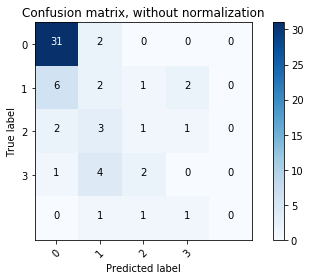

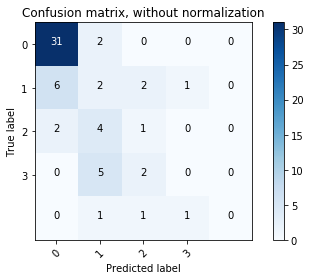

In [0]:
# Task 3 part (c)
# Add your code here

frames = [df_1, df_2]

for df in frames:
  # Separating the data and the labels
  X = np.asarray(df[df.columns[:-1]]).astype(np.float32)
  y = np.asarray(df.prediction)

  # Splitting the data into the train and the test sets
  sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
  sss.get_n_splits(X, y)

  train_index, test_index = next(sss.split(X, y))
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  # Creating a SVM classifier instance
  svc = SVC()

  # Add a scaler here (If you don't add anything here, your code won't execute!)
  data_scaler = StandardScaler()

  # Update the pipeline by adding the scaler from the previous line
  model = make_pipeline(data_scaler, svc)
  param_grid = {'svc__C': [1, 5, 10, 50],
                'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}

  grid = GridSearchCV(model, param_grid)
  grid.fit(X_train, y_train)

  # Selecting the best estimator after the parameter search
  model = grid.best_estimator_

  # Predicting the test labels
  y_pred = model.predict(X_test)

  # Printing the classification report
  print(classification_report(y_pred=y_pred,y_true=y_test))

  # Computing the confusion matrix for the test data
  cnf_matrix = confusion_matrix(y_test, y_pred)

  # Plotting the confusion matrix using the previous function
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3],
                        title='Confusion matrix, without normalization')

# Task 4 [10 marks]

### Model Evaluation

For the given confusion matrix, answer the following questions.

In [0]:
!wget http://dev1-kimia.uwaterloo.ca:5000/data/ass2/foo.png

--2020-02-26 19:33:31--  http://dev1-kimia.uwaterloo.ca:5000/data/ass2/foo.png
Resolving dev1-kimia.uwaterloo.ca (dev1-kimia.uwaterloo.ca)... 129.97.229.28
Connecting to dev1-kimia.uwaterloo.ca (dev1-kimia.uwaterloo.ca)|129.97.229.28|:5000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19837 (19K) [image/png]
Saving to: ‘foo.png’

foo.png             100%[===================>]  19.37K  --.-KB/s    in 0.04s   

2020-02-26 19:33:31 (525 KB/s) - ‘foo.png’ saved [19837/19837]



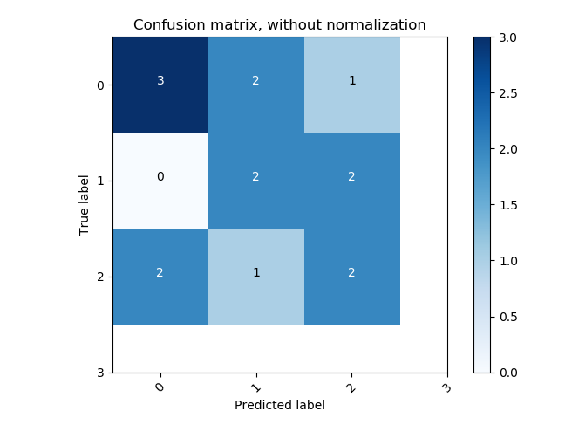

In [0]:
I = plt.imread('/content/foo.png')
fig = plt.figure(figsize= (10,10))
plt.imshow(I)
plt.axis('off')
plt.show()


#### Calculate the following parameters (Use micro-average definition)

You can find all these definitions on https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html 
 and https://en.wikipedia.org/wiki/Confusion_matrix
 
 Write your answer in front of each parameter:

1- [1 score] total number of instances = 15

2- [1 score] number of classes = 3

3- [1 score] True positive (TP) = 2.333

4- [1 score] True negative (TN) = 7.333

5- [1 score] False positive (FP) = 2.667

6- [1 score] False negative (FN) = 2.667

7- [1 score] Sensitivity, recall, hit rate, or true positive rate (TPR) = 0.467

8- [1 score] Specificity, selectivity or true negative rate (TNR) = 0.733

9- [2 scores] F1-Score = 0.467

# Task 5 [20 marks]

## kmeans objective function
The objective function for kmeans clustering is as follows: 

$$E(S,\mu)= \sum_{k=1}^K \sum_{p\in S^k}\|f_p-\mu_k \|^2 \tag{1}$$

where $S^k$ is set of data points in $k_{th}$ cluster and $\mu_k$ is mean of data points in $k_{th}$ cluster. If we replace the fromula for calculating $\mu_k$ (sample mean):$\mu_k=\frac{1}{|S^k|}\sum_{p\in S^k}^K f_p$ $\enspace$ ($|S^k|$ is number of data points in $k_{th}$ cluster) in equation (1) the non-parametric version of kmeans objective function can be obtained and that is:


$$E(S)=\sum_{k=1}^K \frac{\sum_{pq\in S^k}\|f_p-f_q\|^2}{2\;|S^k|} \tag{2}$$

where $f_p$ and $f_q$ are $p_{th}$ and $q_{th}$ data points in $S^k$.

### a) Show that this non-parametric objective function can be written as:

$$E(S)=\sum_{k=1}^K  |S^k|.    var(S^k)$$ where $var(S^k)$ is sample variance of data points in $S^k$.

### b) Show the following equivalance for the nonparametric formulation of kmeans objective function:

$$ E(S)= \sum_{k=1}^K \frac{\sum_{pq\in S^k}\|f_p-f_q\|^2}{2\;|S^k|} \;\;=\;\; const - \sum_{k=1}^K \frac{\sum_{pq\in S^k} \langle f_p,f_q\rangle}{|S^k|}$$

Where $const$ is a constant and $\langle f_p,f_q\rangle$ is dot product of $f_p$ and $f_q$.

# Task 6 [10 marks]

## color quantization using kmeans 
### step 1 image to data matrix

Write a function that takes an image and return a numpy array where number of rows are equal to number of pixels and number columns is equal to 3 representing $[R,G,B]$ 

In [0]:
def image_to_data(image):
    
  # write your code here
  img_list = np.asarray(image)
  data_matrix = []
  
  for chunk in img_list:
    for pixel in chunk:
      data_matrix.append(pixel)

  return np.asarray(data_matrix)

### step 2 use elbow method and find number of clusters
In the following a sample image is provided in image variable. Use image_to_data function that you wrote in the step 1 and calculate data_matrix. Then write a peace of code that implements elbow method and apply that on data_matrix.
Find optimal value of number of clusters data_matrix and put this value in number_of_custers.  

In [0]:
# loading sample image
from skimage.io import imread
from sklearn.datasets import load_sample_image
image = load_sample_image('flower.jpg')

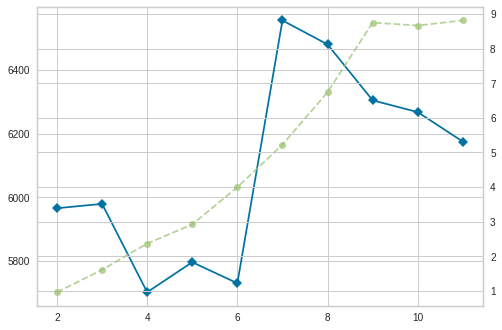

In [0]:
# write your code for elbow method here
from sklearn.cluster import KMeans

#this library builds the elbow method graph using a distortion score
from yellowbrick.cluster import KElbowVisualizer

data_matrix = image_to_data(image)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12), locate_elbow=True)

visualizer.fit(data_matrix)

#store optimal value for number of clusters here in number_of_custers
number_of_custers=5

Here, the dotted green line represents the amount of time it took to generate the k clusters.

### step 3 apply kmeans on data matrix
The data_matrix that you calculated in step 2, is a three dimensional representation of the image. So the squared error between RGB feture $F_p=[R_p,G_p,B_p]$ at any pixel $p$ and any given cluster mean $m=[R_m,G_m,B_m]$ is 
#### $$||F_p - m||^2 = (R_p - R_m)^2 + (G_p - G_m)^2 + (B_p - B_m)^2.$$

Use sklearn to apply kmeans on data_matrix. Please use the optimal value for number of clusters that you found in step 2.

After applying kmeans, for each data point (row in data_matrix) you have a 3 vector which is the closest cluster center to that data point or equally center of the cluster this data point belongs to. 

For each data point, find the closest cluster center which is a 3 vector and bring back these values in the image shape and visualize that as an iamge using plt.imshow().



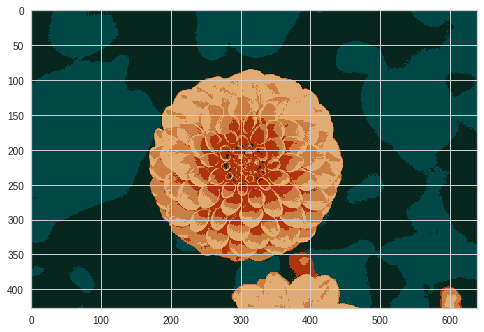

In [0]:
# write your code here 

from sklearn.cluster import KMeans
from scipy.spatial import distance
from operator import itemgetter

kmeans = KMeans(n_clusters=5).fit(data_matrix)

#returns closest cluster center to input point
def closest_cluster(point, means=kmeans.cluster_centers_):
  #get list of distances
  distances = distance.cdist(np.array(means), np.array([point]), 'euclidean')
  #get index of smallest distance cluster mean
  min_index = min(enumerate(distances), key=itemgetter(1))[0] 
  return means[min_index]

#get closest cluster center for each pixel and build image data
means_matrix = np.array([[0, 0, 0]]) #trick to enable np.vstack 
for point in data_matrix:
  closest = closest_cluster(point)
  means_matrix = np.vstack((means_matrix, closest))

#remove extra means_matrix entry
means_matrix = np.delete(means_matrix, 0, 0)
#reshape matrix to fit plt.imshow requirements
means_matrix = np.reshape(means_matrix, (427, 640, 3))
# plot image from cluster centers
plt.imshow(means_matrix.astype(int))


# Task 7 [10 marks]
## SOM
Use minisom package, create a latice with size of (40,40) and map train_data (which consits of 15 colors) to this lattice. 
put the earning_rate=0.5, sigma=4, and 1000 iterations for trainig your model.

In [0]:
!pip install minisom

  Created wheel for minisom: filename=MiniSom-2.2.3-cp36-none-any.whl size=7550 sha256=95ac0a4aa661c35f3f11c805927694e4bfd5f33ce851daf49d3c959af49ef46a
  Stored in directory: /root/.cache/pip/wheels/35/62/79/4d921062c847ee15a3bb3ac2ea984ed401c8b6b2944f08f697
Successfully built minisom


In [0]:
from minisom import MiniSom

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload

#Training inputs for RGBcolors
train_data = np.array(
     [[0., 0., 0.],
      [0., 0., 1.],
      [0., 0., 0.5],
      [0.125, 0.529, 1.0],
      [0.33, 0.4, 0.67],
      [0.6, 0.5, 1.0],
      [0., 1., 0.],
      [1., 0., 0.],
      [0., 1., 1.],
      [1., 0., 1.],
      [1., 1., 0.],
      [1., 1., 1.],
      [.33, .33, .33],
      [.5, .5, .5],
      [.66, .66, .66]])
color_names = ['black', 'blue', 'darkblue', 'skyblue',
     'greyblue', 'lilac', 'green', 'red',
     'cyan', 'violet', 'yellow', 'white',
     'darkgrey', 'mediumgrey', 'lightgrey']

from minisom import MiniSom   
# define your model here
#som = MiniSom(40,40,3,sigma=4.0,learning_rate=0.5) #sigma = 4
som = MiniSom(40,40,3,sigma=1.0,learning_rate=0.5) #sigma = 1
som.random_weights_init(train_data)

# train your model:
som.train_random(train_data,1000, verbose=True)

# after training the som, extract the weights of neurons and store them in variable som_weights
som_weights = som.get_weights()

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 6.406840336003418e-19
 topographic error: 0.5333333333333333


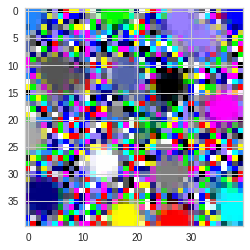

In [0]:
#Run this to visualize the result for sigma = 4
plt.imshow(abs(som_weights), interpolation='none')

change the value of sigma to 1 and get the results again. Explain the difference you see.

We can see that with a sigma value of 4, the groupings are large and colors are not intermixed (with the exception of the edges of the groupings). The quantization error is very small and the topographic error is 0 using sigma=4. With a sigma value of 1 however, there are still clear color groups but they are much smaller and there is significantly more mixing amongst the colors. Here, the quantization error is smaller than that of sigma=4 but the topographic error is ~0.5 which is very large.

This makes sense as sigma represents the radius of the different neighbours in the SOM.

In [0]:
# Assignment end